<cell_type>markdown</cell_type># 3D FEA — CalculiX (Extruded Geometry)

Full 3D CalculiX analysis of the CCS bistable **half-beam** with `C3D10`
(10-node tetrahedral) elements.

**Boundary conditions**:
- Anchor (x≈0): clamped, u_x = u_y = u_z = 0
- Shuttle (x≈L): prescribe u_y, u_x and u_z free

In [1]:
import sys
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import meshio
import shutil

sys.path.insert(0, os.path.dirname(os.path.abspath("__file__")))
from beam_utils import (
    POLY_SI, DEFAULT_BEAM_PARAMS, get_beam_polygon,
)

L = DEFAULT_BEAM_PARAMS["half_span"]   # 20 µm
h = DEFAULT_BEAM_PARAMS["initial_offset"]  # 1.2 µm
t = POLY_SI["t"]
E = POLY_SI["E"]
nu = POLY_SI["nu"]

CCX = shutil.which('ccx') or os.path.abspath('../../switch-env/bin/ccx')
CCX_DIR = os.path.abspath('results/ccx_3d')
os.makedirs(CCX_DIR, exist_ok=True)
print(f"CalculiX: {CCX}")
print(f"Half-beam: L={L} µm, h={h} µm, t={t} µm")

CalculiX: /Users/neekon/git/mcw/mcw-mems-photonic-switch/switch-env/bin/ccx
Half-beam: L=20.0 µm, h=1.2 µm, t=0.5 µm


## 1. 3D Mesh Generation

In [2]:
poly = get_beam_polygon(n_points=200)
if np.allclose(poly[0], poly[-1]):
    poly = poly[:-1]

gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 0)
gmsh.model.add("ccs_beam_3d_ccx")

L_flex = DEFAULT_BEAM_PARAMS["flex_ratio"] * L
# Coarser mesh for tractable 3D CalculiX solve times
lc_flex = 0.4
lc_rigid = 0.7

point_tags = []
for x, y in poly:
    in_flex = (x < L_flex + 1) or (x > L - L_flex - 1)
    lc = lc_flex if in_flex else lc_rigid
    point_tags.append(gmsh.model.occ.addPoint(x, y, 0, lc))

line_tags = []
for i in range(len(point_tags)):
    j = (i + 1) % len(point_tags)
    line_tags.append(gmsh.model.occ.addLine(point_tags[i], point_tags[j]))

wire = gmsh.model.occ.addCurveLoop(line_tags)
surf = gmsh.model.occ.addPlaneSurface([wire])

n_layers_z = 3
extrude = gmsh.model.occ.extrude([(2, surf)], 0, 0, t,
                                  numElements=[n_layers_z], recombine=False)

gmsh.model.occ.synchronize()
gmsh.model.mesh.generate(3)
gmsh.model.mesh.setOrder(2)

tmp_msh = os.path.join(CCX_DIR, 'beam3d.msh')
gmsh.write(tmp_msh)

node_tags, coords, _ = gmsh.model.mesh.getNodes()
print(f"3D mesh: {len(node_tags)} nodes (2nd order)")
gmsh.finalize()

3D mesh: 43505 nodes (2nd order)



Mesh: 43505 nodes, 26172 elements, type=C3D10


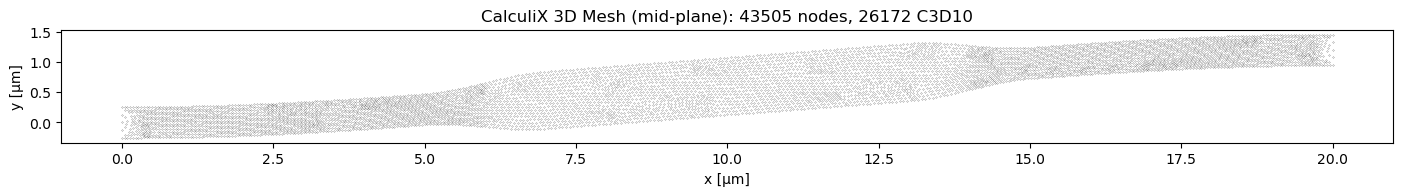

In [3]:
# Read mesh
msh = meshio.read(tmp_msh)

# Find tet10 cells
tet_cells = None
for cb in msh.cells:
    if cb.type == 'tetra10':
        tet_cells = cb.data
        break
    elif cb.type == 'tetra':
        tet_cells = cb.data
        break

points_3d = msh.points
elem_type = 'C3D10' if tet_cells is not None and tet_cells.shape[1] == 10 else 'C3D4'
print(f"Mesh: {len(points_3d)} nodes, {len(tet_cells)} elements, type={elem_type}")

# Visualize (mid-plane)
fig, ax = plt.subplots(figsize=(14, 4))
z_mid = t / 2
mid_mask = np.abs(points_3d[:, 2] - z_mid) < 0.08
ax.plot(points_3d[mid_mask, 0], points_3d[mid_mask, 1], 'k.', ms=0.3)
ax.set_aspect('equal')
ax.set_title(f'CalculiX 3D Mesh (mid-plane): {len(points_3d)} nodes, {len(tet_cells)} {elem_type}')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
fig.tight_layout()
fig.savefig('plots/calculix_3d_mesh.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Boundary Nodes

In [4]:
tol = 0.05
# Anchor nodes (x ≈ 0): fully clamped
anchor_3d = np.where(points_3d[:, 0] < tol)[0] + 1  # 1-indexed

# Shuttle nodes (x ≈ L): prescribe y-displacement
shuttle_3d = np.where(points_3d[:, 0] > L - tol)[0] + 1

print(f"Anchor: {len(anchor_3d)}, Shuttle: {len(shuttle_3d)}")

Anchor: 49, Shuttle: 49


## 3. Write and Run CalculiX

In [5]:
def write_nset(f, name, nids, per_line=16):
    """Write a node set to CalculiX .inp file."""
    f.write(f'*NSET, NSET={name}\n')
    for j, nid in enumerate(nids):
        f.write(f'{nid}')
        if (j + 1) % per_line == 0 or j == len(nids) - 1:
            f.write('\n')
        else:
            f.write(', ')


def write_ccx_3d_input(filepath, points, elems, elem_type,
                        anchor_nids, shuttle_nids, delta, E, nu):
    """Write CalculiX .inp file for 3D half-beam analysis.
    
    BCs: anchor clamped (all DOFs=0), shuttle y-prescribed (DOF 2).
    """
    with open(filepath, 'w') as f:
        f.write('*HEADING\n')
        f.write('CCS Bistable Half-Beam - 3D\n**\n')
        
        f.write('*NODE\n')
        for i, (x, y, z) in enumerate(points):
            f.write(f'{i+1}, {x:.8f}, {y:.8f}, {z:.8f}\n')
        
        f.write(f'*ELEMENT, TYPE={elem_type}, ELSET=BEAM\n')
        for i, conn in enumerate(elems):
            node_str = ', '.join(str(n+1) for n in conn)
            f.write(f'{i+1}, {node_str}\n')
        
        write_nset(f, 'ANCHOR', anchor_nids)
        write_nset(f, 'SHUTTLE', shuttle_nids)
        
        f.write('*MATERIAL, NAME=POLYSI\n')
        f.write('*ELASTIC\n')
        f.write(f'{E:.1f}, {nu:.4f}\n')
        
        f.write('*SOLID SECTION, ELSET=BEAM, MATERIAL=POLYSI\n\n')
        
        f.write('*STEP, NLGEOM, INC=1000\n')
        f.write('*STATIC\n')
        f.write('0.05, 1.0, 1e-8, 0.2\n')
        
        # Anchor: clamp all 3 DOFs
        f.write('*BOUNDARY\n')
        f.write('ANCHOR, 1, 3, 0.0\n')
        
        # Shuttle: prescribe y only (DOF 2)
        f.write('*BOUNDARY\n')
        f.write(f'SHUTTLE, 2, 2, {delta:.8f}\n')
        
        f.write('*NODE FILE\n')
        f.write('U, RF\n')
        f.write('*NODE PRINT, NSET=SHUTTLE, TOTALS=YES\n')
        f.write('RF\n')
        
        f.write('*END STEP\n')

print("Input writer ready.")

Input writer ready.


In [6]:
def parse_ccx_reaction_force(dat_file):
    """Parse total reaction force (y-component) from .dat file.
    
    CalculiX .dat format:
        total force (fx,fy,fz) for set SHUTTLE and time  1.0000000E+00
        
               -1.703979E-08 -8.322464E+00  5.967588E-13
    
    Values are on the line AFTER the 'total force' header.
    Returns the LAST total force entry (final converged increment).
    """
    with open(dat_file, 'r') as f:
        lines = f.readlines()
    rf_y = None
    for i, line in enumerate(lines):
        if 'total force' in line.lower():
            # Values are on the next non-blank line
            for j in range(i + 1, min(i + 5, len(lines))):
                parts = lines[j].split()
                if len(parts) >= 2:
                    try:
                        rf_y = float(parts[1])  # fy is second column
                        break
                    except ValueError:
                        continue
    return rf_y

# Displacement sweep — reduced to 20 steps for tractable runtime
n_ccx_3d = 20
delta_ccx_3d = np.linspace(0, -2*h, n_ccx_3d)
delta_ccx_3d[0] = -0.01
F_ccx_3d = np.zeros(n_ccx_3d)

for i, delta in enumerate(delta_ccx_3d):
    job = f'step_{i:03d}'
    inp_file = os.path.join(CCX_DIR, f'{job}.inp')
    
    write_ccx_3d_input(inp_file, points_3d, tet_cells, elem_type,
                        anchor_3d, shuttle_3d, delta, E, nu)
    
    result = subprocess.run(
        [CCX, '-i', job],
        cwd=CCX_DIR,
        capture_output=True, text=True, timeout=300
    )
    
    dat_file = os.path.join(CCX_DIR, f'{job}.dat')
    if os.path.exists(dat_file):
        rf = parse_ccx_reaction_force(dat_file)
        if rf is not None:
            F_ccx_3d[i] = rf
        else:
            print(f"  Step {i}: parse failed")
    else:
        print(f"  Step {i}: ccx failed — {result.stderr[:200] if result.stderr else 'no stderr'}")
    
    if i % 5 == 0:
        print(f"  Step {i}/{n_ccx_3d}: δ={delta:.3f} µm, F={F_ccx_3d[i]:.4f} µN")

delta_ccx_3d[0] = 0.0
F_ccx_3d[0] = 0.0
print(f"CalculiX 3D sweep complete. F range: [{F_ccx_3d.min():.4f}, {F_ccx_3d.max():.4f}] µN")

  Step 0/20: δ=-0.010 µm, F=-0.0099 µN
  Step 5/20: δ=-0.632 µm, F=-0.6252 µN
  Step 10/20: δ=-1.263 µm, F=-1.2517 µN
  Step 15/20: δ=-1.895 µm, F=-1.8848 µN
CalculiX 3D sweep complete. F range: [-2.3995, 0.0000] µN


## 4. Results

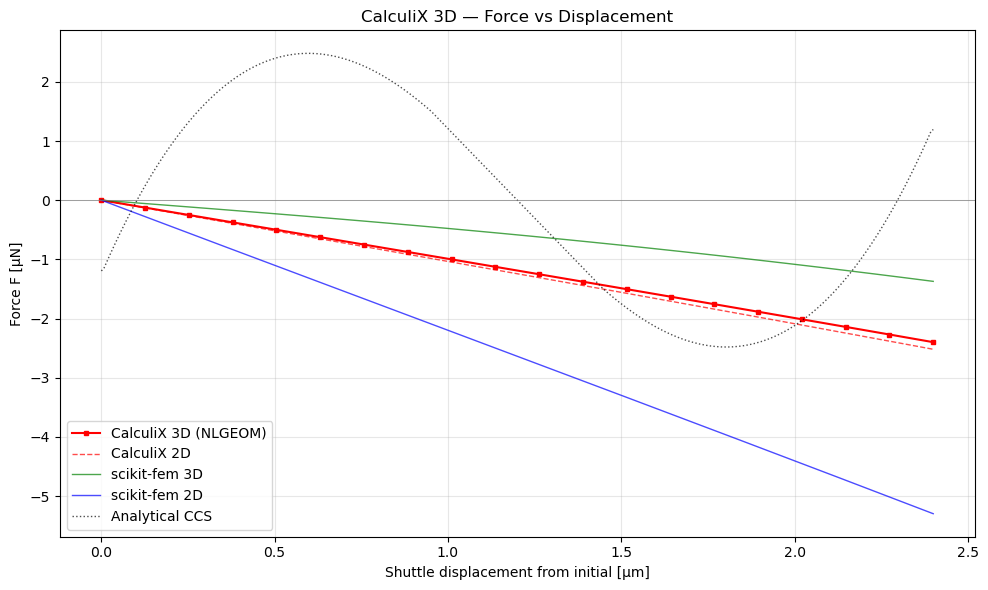

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(-delta_ccx_3d, F_ccx_3d, 'rs-', linewidth=1.5, ms=3,
        label='CalculiX 3D (NLGEOM)')

# Overlay other results
for fname, label, style in [
    ('results/calculix_2d_force_displacement.csv', 'CalculiX 2D', 'r--'),
    ('results/skfem_3d_force_displacement.csv', 'scikit-fem 3D', 'g-'),
    ('results/skfem_2d_force_displacement.csv', 'scikit-fem 2D', 'b-'),
    ('results/analytical_force_displacement.csv', 'Analytical CCS', 'k:'),
]:
    try:
        data = np.loadtxt(fname, delimiter=',', skiprows=1)
        col = 2 if 'analytical' in fname else 1
        ax.plot(data[:, 0], data[:, col], style, linewidth=1, alpha=0.7,
                label=label)
    except FileNotFoundError:
        pass

ax.axhline(0, color='gray', linewidth=0.5)
ax.set_xlabel('Shuttle displacement from initial [µm]')
ax.set_ylabel('Force F [µN]')
ax.set_title('CalculiX 3D — Force vs Displacement')
ax.legend()
ax.grid(True, alpha=0.3)

fig.tight_layout()
fig.savefig('plots/calculix_3d_force_displacement.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# Save results
np.savetxt('results/calculix_3d_force_displacement.csv',
           np.column_stack([-delta_ccx_3d, F_ccx_3d]),
           delimiter=',',
           header='delta_um,F_uN',
           comments='')
print("Saved: results/calculix_3d_force_displacement.csv")

Saved: results/calculix_3d_force_displacement.csv


---
# Cross-Method Comparison

Overlay all force-displacement curves and tabulate critical values.

In [9]:
# Load all available results
results = {}

file_specs = [
    ('Analytical (uniform)', 'results/analytical_force_displacement.csv', 1),
    ('Analytical (CCS)', 'results/analytical_force_displacement.csv', 2),
    ('scikit-fem 2D', 'results/skfem_2d_force_displacement.csv', 1),
    ('scikit-fem 3D', 'results/skfem_3d_force_displacement.csv', 1),
    ('CalculiX 2D', 'results/calculix_2d_force_displacement.csv', 1),
    ('CalculiX 3D', 'results/calculix_3d_force_displacement.csv', 1),
]

for name, fpath, col in file_specs:
    try:
        data = np.loadtxt(fpath, delimiter=',', skiprows=1)
        results[name] = {'delta': data[:, 0], 'F': data[:, col]}
        print(f"Loaded: {name} ({len(data)} points)")
    except FileNotFoundError:
        print(f"Not found: {fpath}")

Loaded: Analytical (uniform) (300 points)
Loaded: Analytical (CCS) (300 points)
Loaded: scikit-fem 2D (200 points)
Loaded: scikit-fem 3D (30 points)
Loaded: CalculiX 2D (50 points)
Loaded: CalculiX 3D (20 points)


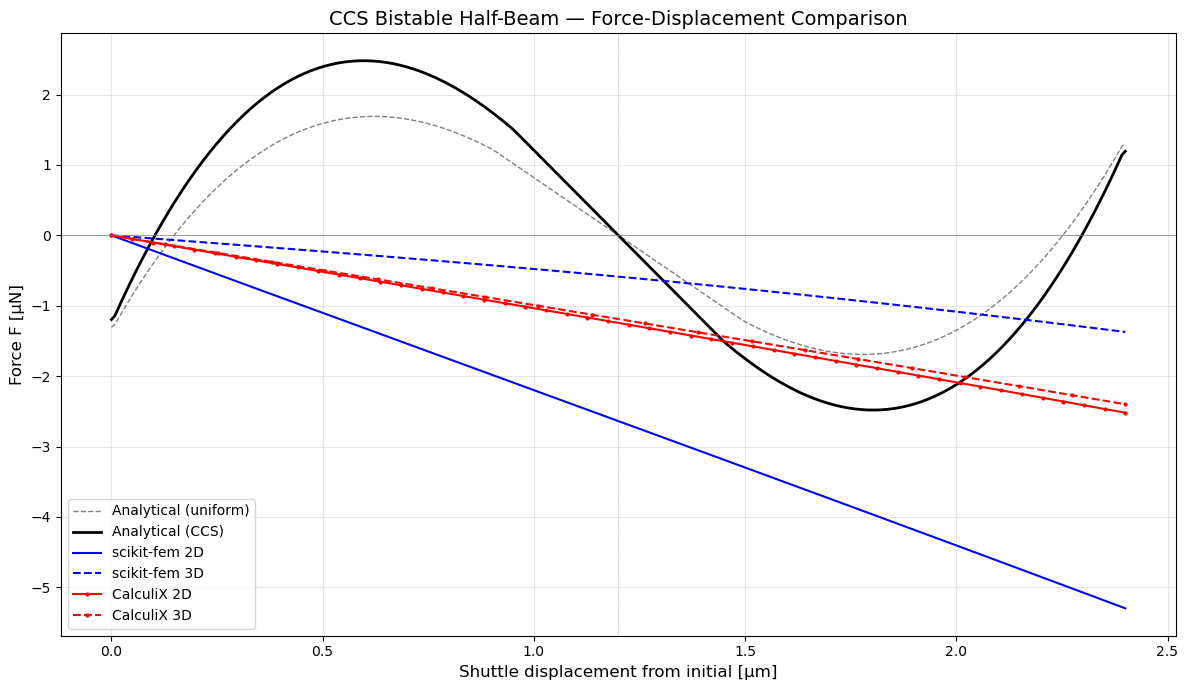

In [10]:
# Comparison plot
fig, ax = plt.subplots(figsize=(12, 7))

styles = {
    'Analytical (uniform)': ('gray', '--', 1.0),
    'Analytical (CCS)':     ('black', '-', 2.0),
    'scikit-fem 2D':        ('blue', '-', 1.5),
    'scikit-fem 3D':        ('blue', '--', 1.5),
    'CalculiX 2D':          ('red', '-', 1.5),
    'CalculiX 3D':          ('red', '--', 1.5),
}

for name, d in results.items():
    color, ls, lw = styles.get(name, ('green', '-', 1.0))
    marker = 'o' if 'CalculiX' in name else ''
    ax.plot(d['delta'], d['F'], color=color, linestyle=ls, linewidth=lw,
            marker=marker, markersize=2, label=name)

ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(h, color='gray', linewidth=0.5, linestyle=':')
ax.set_xlabel('Shuttle displacement from initial [µm]', fontsize=12)
ax.set_ylabel('Force F [µN]', fontsize=12)
ax.set_title('CCS Bistable Half-Beam — Force-Displacement Comparison', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

fig.tight_layout()
fig.savefig('plots/comparison_force_displacement.png', dpi=200, bbox_inches='tight')
plt.show()

In [11]:
# Critical values table
import csv

print(f"{'Method':25s} {'F_push [µN]':>12s} {'F_pop [µN]':>12s} {'|F_pop/F_push|':>14s}")
print('-' * 65)

rows = []
for name, d in results.items():
    F = d['F']
    delta = d['delta']
    F_push = F.max()
    F_pop = F.min()
    ratio = abs(F_pop / F_push) if abs(F_push) > 1e-10 else 0.0
    
    # Find snap-through displacement (first zero crossing after peak)
    idx_peak = np.argmax(F)
    zero_after = np.where(np.diff(np.sign(F[idx_peak:])))[0]
    delta_snap = delta[idx_peak + zero_after[0]] if len(zero_after) > 0 else 0.0
    
    print(f"{name:25s} {F_push:12.4f} {F_pop:12.4f} {ratio:14.4f}")
    rows.append([name, f'{F_push:.6f}', f'{F_pop:.6f}', f'{ratio:.4f}',
                 f'{delta_snap:.4f}', f'{2*h:.4f}'])

# Save comparison table
with open('results/comparison_critical_values.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['method', 'F_push_uN', 'F_pop_uN', 'push_pop_ratio',
                     'delta_snap_um', 'total_travel_um'])
    writer.writerows(rows)

print(f"\nSaved: results/comparison_critical_values.csv")

Method                     F_push [µN]   F_pop [µN] |F_pop/F_push|
-----------------------------------------------------------------
Analytical (uniform)            1.6909      -1.6909         1.0000
Analytical (CCS)                2.4814      -2.4814         1.0000
scikit-fem 2D                   0.0000      -5.2984         0.0000
scikit-fem 3D                   0.0000      -1.3718         0.0000
CalculiX 2D                     0.0000      -2.5197         0.0000
CalculiX 3D                     0.0000      -2.3995         0.0000

Saved: results/comparison_critical_values.csv
